# Logistic Regression Model With Beach Gaze Data Chopped Up Per Question - With Contamination*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Important: Double check your file paths and folder structure

In [3]:
# Using each users' chopped up eye tracking data
# Get the project root directory
# Try to find project root by looking for "Chopped DGMs Unorganized" folder
current_dir = os.getcwd()
project_root = current_dir

# Navigate up to find project root (where "Chopped DGMs Unorganized" exists)
for _ in range(3):  # Check up to 3 levels up
    if os.path.exists(os.path.join(current_dir, "Chopped DGMs Unorganized")):
        project_root = current_dir
        break
    parent = os.path.dirname(current_dir)
    if parent == current_dir:  # Reached filesystem root
        break
    current_dir = parent

# Data folder: Chopped DGMs Unorganized (at project root)
data_folder = os.path.join(project_root, "Chopped DGMs Unorganized")

# Path to literacy results CSV (relative to project root)
target_csv_path = os.path.join(project_root, "Code", "Utilities", "users_literacy_results.csv")

# Print paths for verification
print(f"Project root: {project_root}")
print(f"Data folder: {data_folder}")
print(f"CSV path: {target_csv_path}")

# Load target CSV
literacy_df = pd.read_csv(target_csv_path)

literacy_dict = dict(zip(literacy_df['MEDIA_ID'], literacy_df['LITERACY']))

Project root: c:\Users\tonyg\OneDrive\Desktop\University Files\Eye Tracking Research
Data folder: c:\Users\tonyg\OneDrive\Desktop\University Files\Eye Tracking Research\Chopped DGMs Unorganized
CSV path: c:\Users\tonyg\OneDrive\Desktop\University Files\Eye Tracking Research\Code\Utilities\users_literacy_results.csv


In [4]:
# Columns with NaNs to explicitly remove
nan_columns = [
    'mean_peak_saccade_velocity', 'median_peak_saccade_velocity', 'std_peak_saccade_velocity',
    'min_peak_saccade_velocity', 'max_peak_saccade_velocity', 'mean_mean_saccade_velocity',
    'median_mean_saccade_velocity', 'std_mean_saccade_velocity', 'min_mean_saccade_velocity',
    'max_mean_saccade_velocity', 'average_blink_rate_per_minute', 'stdev_of_relative_degrees'
]

In [5]:
# Collect all DGM CSV files
csv_files = []
for user_id in range(1, 33):
    # Skip user 5 and user 20
    if user_id == 5 or user_id == 20:
        continue

    # user_X folder in Chopped DGMs Unorganized
    user_folder = os.path.join(data_folder, f"user_{user_id}")

    if os.path.exists(user_folder):
        for question_id in range(1, 51):
            # user_X_question_Y_DGMs.csv
            dgm_file = os.path.join(user_folder, f"user_{user_id}_question_{question_id}_DGMs.csv")

            if os.path.exists(dgm_file):
                csv_files.append(dgm_file)

print(f"Collected {len(csv_files)} DGM CSV files.")

Collected 1499 DGM CSV files.


In [6]:
csv_files

['c:\\Users\\tonyg\\OneDrive\\Desktop\\University Files\\Eye Tracking Research\\Chopped DGMs Unorganized\\user_1\\user_1_question_1_DGMs.csv',
 'c:\\Users\\tonyg\\OneDrive\\Desktop\\University Files\\Eye Tracking Research\\Chopped DGMs Unorganized\\user_1\\user_1_question_2_DGMs.csv',
 'c:\\Users\\tonyg\\OneDrive\\Desktop\\University Files\\Eye Tracking Research\\Chopped DGMs Unorganized\\user_1\\user_1_question_3_DGMs.csv',
 'c:\\Users\\tonyg\\OneDrive\\Desktop\\University Files\\Eye Tracking Research\\Chopped DGMs Unorganized\\user_1\\user_1_question_4_DGMs.csv',
 'c:\\Users\\tonyg\\OneDrive\\Desktop\\University Files\\Eye Tracking Research\\Chopped DGMs Unorganized\\user_1\\user_1_question_5_DGMs.csv',
 'c:\\Users\\tonyg\\OneDrive\\Desktop\\University Files\\Eye Tracking Research\\Chopped DGMs Unorganized\\user_1\\user_1_question_6_DGMs.csv',
 'c:\\Users\\tonyg\\OneDrive\\Desktop\\University Files\\Eye Tracking Research\\Chopped DGMs Unorganized\\user_1\\user_1_question_7_DGMs.csv',

In [9]:
# Feature data storage
feature_data = []
labels = []

# Load each DGM file and remove specified NaN columns
import re

for file_path in csv_files:
    df = pd.read_csv(file_path)
    
    # Extract user_id from file path using regex (handles Windows/Unix paths)
    # Pattern: user_X_question_Y_DGMs.csv or path/user_X/user_X_question_Y_DGMs.csv
    match = re.search(r'user_(\d+)_question', os.path.basename(file_path))
    if match:
        user_id = int(match.group(1))
    else:
        print(f"Warning: Could not extract user_id from {file_path}")
        continue

    # Drop NaN columns
    df_clean = df.drop(columns=nan_columns, errors='ignore')

    if not df_clean.empty:
        feature_data.append(df_clean.iloc[0].values)
        labels.append(literacy_dict.get(user_id))

In [10]:
# Convert feature data to DataFrame
X = pd.DataFrame(feature_data, columns=df_clean.columns)

# Load target values
y = pd.Series(labels)

In [11]:
X.head()

,total_number_of_fixations,sum_of_all_fixation_duration_s,mean_fixation_duration_s,median_fixation_duration_s,stdev_of_fixation_durations_s,min_fixation_duration_s,max_fixation_duration_s,total_number_of_saccades,sum_of_all_saccade_lengths,mean_saccade_length,...,max_relative_degree,convex_hull_area,stationary_entropy,transition_entropy,total_number_of_blinks,total_number_of_valid_recordings,average_pupil_size_of_left_eye,average_pupil_size_of_right_eye,average_pupil_size_of_both_eyes,total_number_of_l_mouse_clicks
0,85.0,17.02742,0.200323,0.188230,0.084545,0.08679,0.44885,84.0,8466.721364,100.794302,...,174.382659,221135.577258,0.0,0.0,0.0,85.0,2.411036,2.682905,2.546971,0.0
1,41.0,10.66517,0.260126,0.213990,0.152612,0.08032,0.74951,40.0,4515.263526,112.881588,...,176.432467,149377.081409,0.0,0.0,0.0,41.0,2.311599,2.586542,2.449071,0.0
2,69.0,14.28263,0.206995,0.193730,0.087603,0.07373,0.58911,68.0,14133.085355,207.839491,...,176.482665,247033.325560,0.0,0.0,0.0,69.0,2.389330,2.500606,2.444968,0.0
3,46.0,8.36803,0.181914,0.177305,0.069501,0.08057,0.42932,45.0,6253.602193,138.968938,...,174.402910,119245.524123,0.0,0.0,0.0,46.0,2.446915,2.717697,2.582306,0.0
4,91.0,17.99108,0.197704,0.177000,0.079244,0.07996,0.43176,90.0,14972.461923,166.360688,...,176.656861,316940.332067,0.0,0.0,0.0,91.0,2.432219,2.598100,2.515160,0.0


In [12]:
X.shape

(1499, 50)

In [13]:
y.head()

0    1
1    1
2    1
3    1
4    1
dtype: int64

In [14]:
y.shape

(1499,)

In [15]:
model = Pipeline([
    ("scaler", StandardScaler()), # Improves model convergence
    ("log_reg", LogisticRegression(max_iter=1000, random_state=42)) # Logistic Regression    
])

In [16]:
# Perform 10-fold CV
cv_scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')

In [17]:
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard deviation: {np.std(cv_scores):.4f}")

Cross-validation scores: [0.71333333 0.8        0.59333333 0.34666667 0.48666667 0.64666667
 0.22666667 0.50666667 0.7        0.71812081]
Mean accuracy: 0.5738
Standard deviation: 0.1724


In [18]:
# Split into train and test with an 70/30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [19]:
print("Training Set Shape (X_train, y_train):", X_train.shape, y_train.shape)
print("Testing Set Shape (X_test, y_test):", X_test.shape, y_test.shape)

Training Set Shape (X_train, y_train): (1049, 50) (1049,)
Testing Set Shape (X_test, y_test): (450, 50) (450,)


In [20]:
model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('log_reg',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [21]:
y_pred = model.predict(X_test)

In [22]:
accuracy = accuracy_score(y_test, y_pred)

accuracy

0.6644444444444444

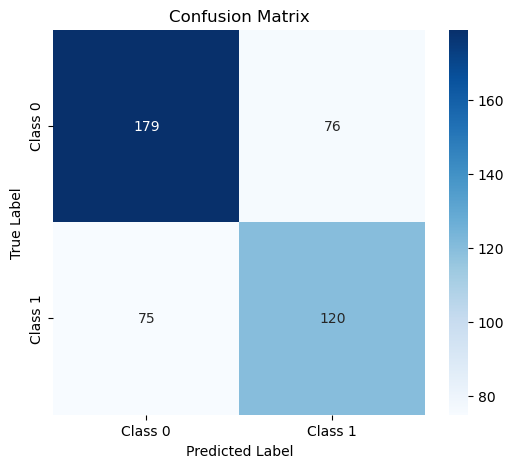

In [23]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Class 0", "Class 1"], 
            yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [24]:
class_report = classification_report(y_test, y_pred)

print(class_report)

              precision    recall  f1-score   support

           0       0.70      0.70      0.70       255
           1       0.61      0.62      0.61       195

    accuracy                           0.66       450
   macro avg       0.66      0.66      0.66       450
weighted avg       0.66      0.66      0.66       450

